# Selectie lot 2024 (2024 Team Selection)

In this problem, you will work with data representing points in a plane specified by their coordinates (X, Y) where 0 <= X, Y <= 100. Within the same region of the plane, [0, 100] x [0, 100], there exists a rectangle with sides parallel to the axes, but whose coordinates are unknown. Any point in the region [0, 100] x [0, 100] will be classified as positive (label 1) if it is inside this rectangle (including its sides) and as negative (label 0) if it is outside of it.

Your task is to build a classifier that, based on a set of training examples (points labeled with 0 or 1), can label any point in the region [0, 100] x [0, 100] as positive (label 1) or negative (label 0) according to the mechanism described above. The performance of the classifier will be measured by its accuracy on a set of test examples.

You will need to investigate three scenarios/situations that will differ by the number of training examples. Each of the three scenarios will be a subtask of the problem. The three scenarios have nothing in common except the mechanism described above, but the rectangle used for classification will not necessarily be the same.

## Evaluation

The evaluation measure is the classification accuracy computed on the test set. The classification accuracy is given by the number of correctly predicted labels divided by the number of test samples.

The partial leaderboard only consists of 10% of the data. You will see your full score after the end of the competition.

In [1]:
import pandas as pd
import torch

In [2]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [3]:
def preprocess(df, subtask_id):
    df = df[df["subtaskID"] == subtask_id]
    return torch.tensor(df[["X", "Y"]].to_numpy()), \
        torch.tensor(df["answer"].to_numpy()) if "answer" in df.columns else None

In [4]:
X_train = []
y_train = []
X_test = []

for i in df_train["subtaskID"].unique():
    X, y = preprocess(df_train, i)
    X_train.append(X)
    y_train.append(y)

    X, _ = preprocess(df_test, i)
    X_test.append(X)

## Visualization

In [5]:
import matplotlib.pyplot as plt

In [6]:
def plot(X_train, y_train, X_test, title=None, rectangle=None):
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=7)
    plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.1, s=7)

    if rectangle is not None:
        min_x, min_y, max_x, max_y = rectangle
        width = max_x - min_x
        height = max_y - min_y
        rect = plt.Rectangle(
            (min_x, min_y), width, height,
            linewidth=1, edgecolor="r", facecolor="none")
        plt.gca().add_patch(rect)

    if title is not None:
        plt.title(title)
    plt.show()

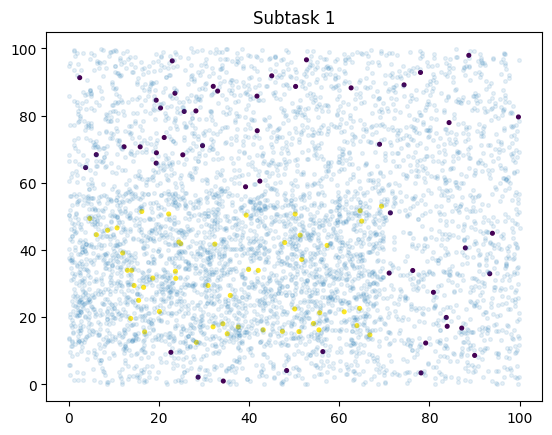

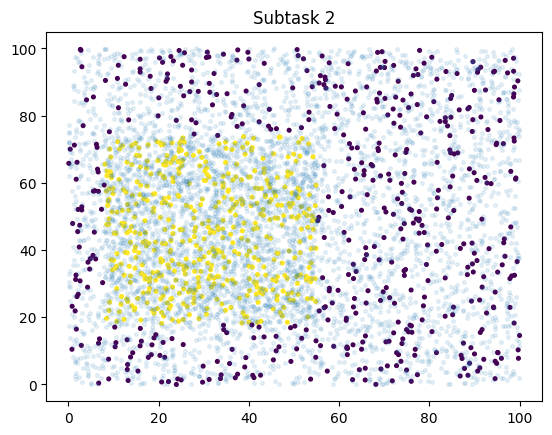

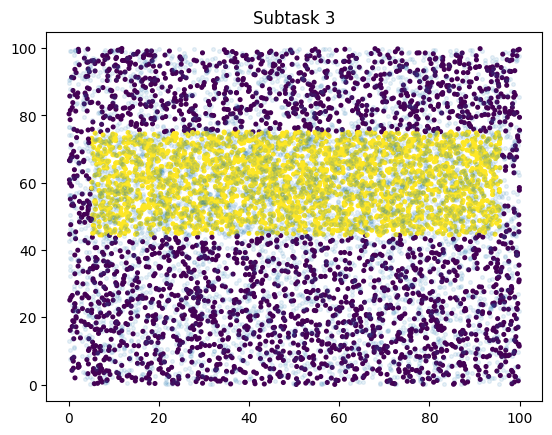

In [7]:
for i in range(len(X_train)):
    plot(X_train[i], y_train[i], X_test[i], f"Subtask {i + 1}")

## Main

In [8]:
def predict(X, params):
    x, y = X[:, 0], X[:, 1]
    x1, y1, x2, y2 = params

    preds = torch.zeros_like(x).int()
    preds[(x1 <= x) & (x <= x2) & (y1 <= y) & (y <= y2)] = 1

    return preds

In [9]:
def save_predictions(fn, csv_filename="submission.csv"):
    submission_rows = []

    for i in range(len(X_train)):
        rectangle = fn(X_train[i], y_train[i])
        preds = predict(X_test[i], rectangle)

        for idx, pred in enumerate(preds.tolist()):
            submission_rows.append((idx + 1, pred, i + 1))

        plot(X_train[i], y_train[i], X_test[i], f"Subtask {i + 1}", rectangle)

    df_submission = pd.DataFrame(submission_rows, columns=["datapointID", "answer", "subtaskID"])
    df_submission.to_csv(csv_filename, index=False)

### Approach 1

In [10]:
def fit_rectangle1(X, y):
    X = X[y == 1]
    return X[:, 0].min(), X[:, 1].min(), X[:, 0].max(), X[:, 1].max()

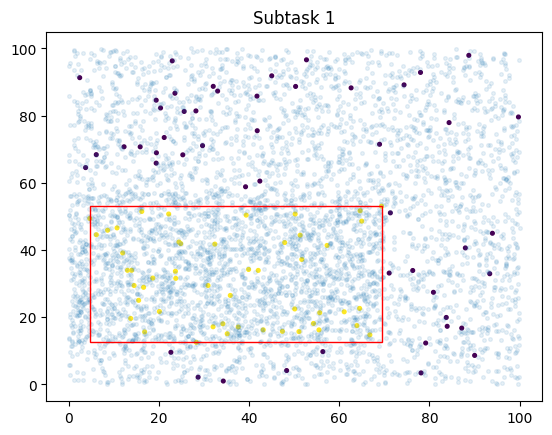

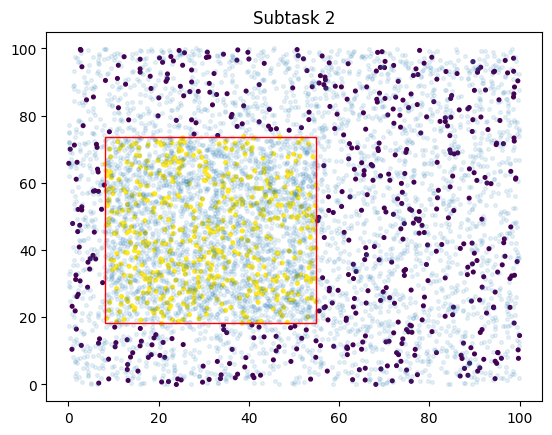

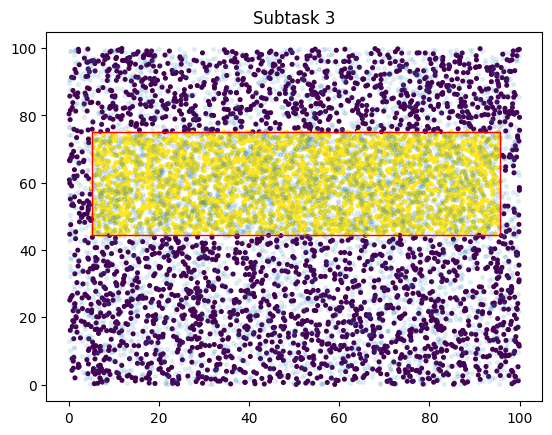

In [11]:
save_predictions(fit_rectangle1, "submission_naive.csv")

### Approach 2

In [12]:
import random
import os
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [13]:
class Model:
    def __init__(self, lr=0.01):
        self.raw_rectangle = torch.tensor([0.] * 4, requires_grad=True)
        self.optimizer = optim.Adam([self.raw_rectangle], lr=lr)

    @property
    def rectangle(self):
        return self.raw_rectangle.sigmoid() * 100

    def soft_predict(self, data):
        x, y = data[:, 0], data[:, 1]

        x1, y1, x2, y2 = self.rectangle

        inside_x = torch.sigmoid(x - x1) * torch.sigmoid(x2 - x)
        inside_y = torch.sigmoid(y - y1) * torch.sigmoid(y2 - y)

        return inside_x * inside_y

    def fit(self, X, y, num_epochs=10000, logging_step=500):
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()

            preds = self.soft_predict(X)
            bce_loss = F.binary_cross_entropy(preds, y.double())

            x1, y1, x2, y2 = self.rectangle
            area_loss = -(y2 - y1) * (x2 - x1) / 100 ** 2

            loss = bce_loss + area_loss * 0.1

            loss.backward()
            self.optimizer.step()

            if epoch % logging_step == 0 or epoch == num_epochs - 1:
                print(f"Epoch {epoch}: loss={loss.item()}")

In [14]:
def fit_rectangle2(X, y):
    model = Model()
    model.fit(X, y)
    return model.rectangle.tolist()

Epoch 0: loss=19.25594515898226
Epoch 500: loss=0.06647948991012713
Epoch 1000: loss=0.00803210273451646
Epoch 1500: loss=-0.002876270069877493
Epoch 2000: loss=-0.006470328541831497
Epoch 2500: loss=-0.008165161424975049
Epoch 3000: loss=-0.009147872812357277
Epoch 3500: loss=-0.009795139503600475
Epoch 4000: loss=-0.010258984160242356
Epoch 4500: loss=-0.010611567846955761
Epoch 5000: loss=-0.010891253175205812
Epoch 5500: loss=-0.011120244471324457
Epoch 6000: loss=-0.011312180607221459
Epoch 6500: loss=-0.01147587234283668
Epoch 7000: loss=-0.011617166594774873
Epoch 7500: loss=-0.01174010800311883
Epoch 8000: loss=-0.011847511575898188
Epoch 8500: loss=-0.01194144230116842
Epoch 9000: loss=-0.012023434832821141
Epoch 9500: loss=-0.012094704644737681
Epoch 9999: loss=-0.012156171031700195


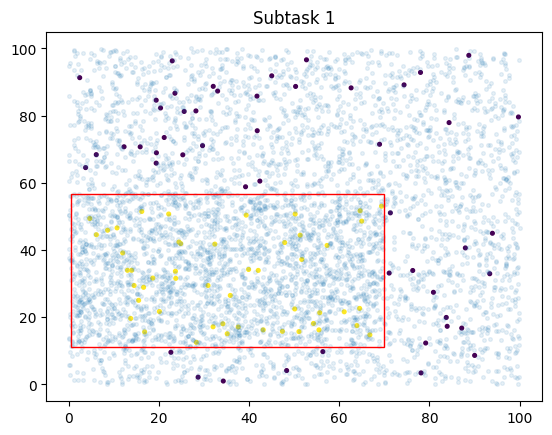

Epoch 0: loss=17.003182937348043
Epoch 500: loss=0.04238914106767258
Epoch 1000: loss=0.009340962318956557
Epoch 1500: loss=0.007578481700977448
Epoch 2000: loss=0.007470978629089332
Epoch 2500: loss=0.007467517649136397
Epoch 3000: loss=0.007467478627117156
Epoch 3500: loss=0.007467480846583892
Epoch 4000: loss=0.007467476640536319
Epoch 4500: loss=0.007467483401571565
Epoch 5000: loss=0.007467481076008441
Epoch 5500: loss=0.007467480409020136
Epoch 6000: loss=0.0074674797351226285
Epoch 6500: loss=0.007467482060400515
Epoch 7000: loss=0.0074674801586269435
Epoch 7500: loss=0.007467479289921662
Epoch 8000: loss=0.007467479928674234
Epoch 8500: loss=0.00746747977199913
Epoch 9000: loss=0.007467481321663666
Epoch 9500: loss=0.007467478066785889
Epoch 9999: loss=0.007468965323927462


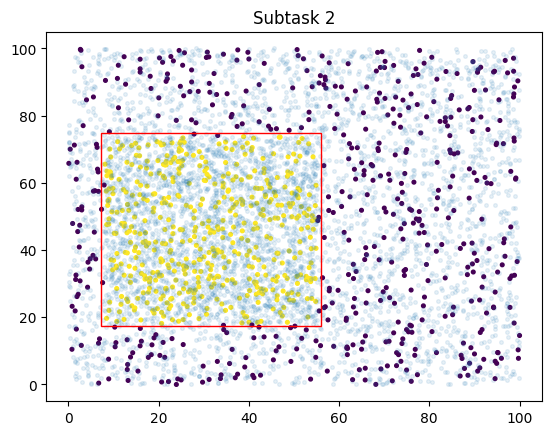

Epoch 0: loss=16.742346356805133
Epoch 500: loss=0.11698933054640148
Epoch 1000: loss=0.02804099207355048
Epoch 1500: loss=0.015701099569777083
Epoch 2000: loss=0.012506773893956241
Epoch 2500: loss=0.01146246019657083
Epoch 3000: loss=0.011081321036354744
Epoch 3500: loss=0.010935662817218098
Epoch 4000: loss=0.010881535808071864
Epoch 4500: loss=0.010863755350837195
Epoch 5000: loss=0.010859098769781188
Epoch 5500: loss=0.010858227265354015
Epoch 6000: loss=0.010858122993483106
Epoch 6500: loss=0.010858116536495842
Epoch 7000: loss=0.010858116034117321
Epoch 7500: loss=0.010858116665868889
Epoch 8000: loss=0.010858118312490811
Epoch 8500: loss=0.010858118509783424
Epoch 9000: loss=0.010858118947948817
Epoch 9500: loss=0.010858123224171776
Epoch 9999: loss=0.010858119712279776


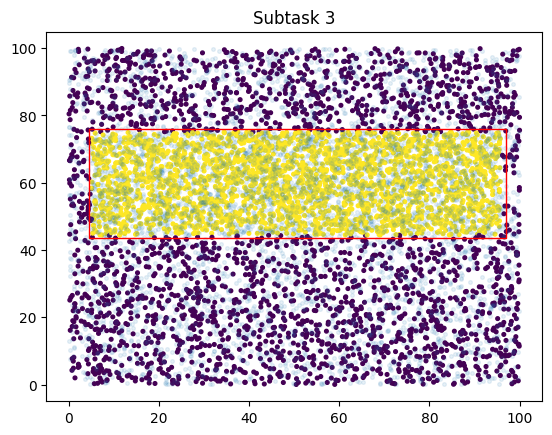

In [15]:
save_predictions(fit_rectangle2)

## Submission results

### Approach 1

Subtask 1:
- Accuracy: 0.9176
- Score: 36/40

Subtask 2:
- Accuracy: 0.992
- Score: 29/30

Subtask 3:
- Accuracy: 0.9988
- Score: 29/30

### Approach 2

Subtask 1:
- Accuracy: 0.9774
- Score: 39/40

Subtask 2:
- Accuracy: 0.99
- Score: 29/30

Subtask 3:
- Accuracy: 0.9868
- Score: 29/30